In [2]:
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.interpolate as interp

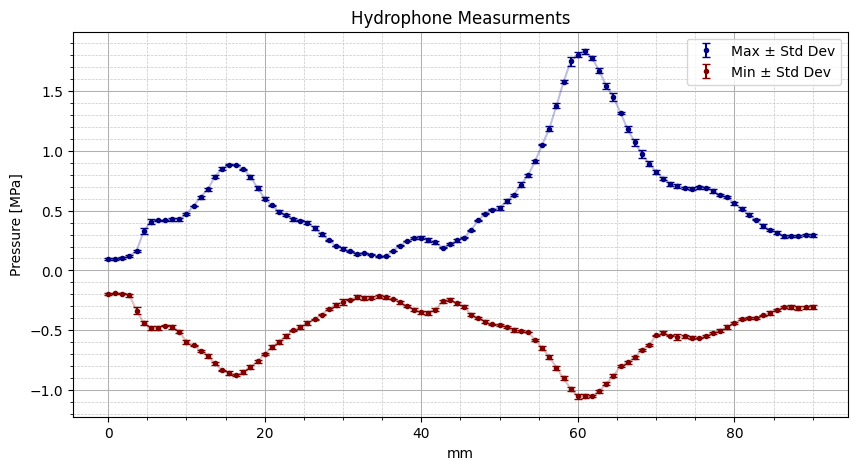

67 1.83
Max pessure was found at: 16750 steps


In [120]:
data_measurement = np.load('Data/01042025/data_raw_20v_FP133-20250401_x2.npy') * 1000  # convert to mV
hydrophone_sensitivity_raw = np.loadtxt('Data/Hydrophone_sensitivity/PAFOH27 + FP133-02T Sensitivity 09January25.txt'
                                        , skiprows=81)
hydrophone_sensitivity_raw[:, 0] = hydrophone_sensitivity_raw[:, 0] * 1e6  # convert to Mhz
num_of_samples = 100
steps_per_sample = 250

steps_per_mm = 275
sampling_rate = 1 / 100e6

slice = (68, 0, 0)

# convert to Pressure: 
data_raw_fft = np.zeros(data_measurement.shape)
data_pressure_fft = np.zeros(data_measurement.shape)
data_pressure = np.zeros(data_measurement.shape)

for i in range(data_measurement.shape[0]):
    for j in range(data_measurement.shape[1]):
        for k in range(data_measurement.shape[2]):
            data_fft = np.fft.fft(data_measurement[i][j][k][:])
            freq = (np.fft.fftfreq(len(data_measurement[i][j][k][:]), sampling_rate))  # sampling rate
            freq = freq / (2 * np.pi)  #convert from rad/s to Hz
            hydrophone_sensitivity = np.interp(freq
                                               , hydrophone_sensitivity_raw[:, 0]
                                               , hydrophone_sensitivity_raw[:, 1])
            out_fft = data_fft / hydrophone_sensitivity
            out = np.fft.ifft(out_fft)

            data_raw_fft[i][j][k] = np.real(data_fft)
            data_pressure_fft[i][j][k] = np.real(out_fft)
            data_pressure[i][j][k][:] = np.real(out)
# Find the Max and Min pressure for each wave form
pressure_max = np.zeros((data_measurement.shape[0], data_measurement.shape[1], data_measurement.shape[2]))
pressure_min = np.zeros((data_measurement.shape[0], data_measurement.shape[1], data_measurement.shape[2]))

for i in range(pressure_max.shape[0]):
    for j in range(pressure_max.shape[1]):
        for k in range(pressure_max.shape[2]):
            pressure_max[i][j][k] = np.percentile(data_pressure[i][j][k][:], 99.9)
            pressure_min[i][j][k] = np.percentile(data_pressure[i][j][k][:], 0.01)

mean_series_max = np.mean(pressure_max, axis=2).squeeze()
mean_series_min = np.mean(pressure_min, axis=2).squeeze()
std_series_max = np.std(pressure_max, axis=2).squeeze()
std_series_min = np.std(pressure_min, axis=2).squeeze()

# Generate x values
x_values = np.arange(num_of_samples) * steps_per_sample / steps_per_mm

# Plot the series with error bars|
plt.figure(figsize=(10, 5))
plt.errorbar(x_values, mean_series_max, yerr=std_series_max, fmt='.', capsize=3, label='Max ± Std Dev', color='navy')
plt.plot(x_values, mean_series_max, color='navy', alpha=0.25)
plt.errorbar(x_values, mean_series_min, yerr=std_series_min, fmt='.', capsize=3, label='Min ± Std Dev', color='maroon')
plt.plot(x_values, mean_series_min, color='maroon', alpha=0.25)
plt.xlabel("mm")
plt.ylabel("Pressure [MPa]")
plt.title("Hydrophone Measurments")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines for minor grid
plt.show()
print(f"{np.argmax(mean_series_max)} {mean_series_max[np.argmax(mean_series_max)]:.2f}")
print(f"Max pessure was found at: {np.argmax(mean_series_max) * steps_per_sample} steps")



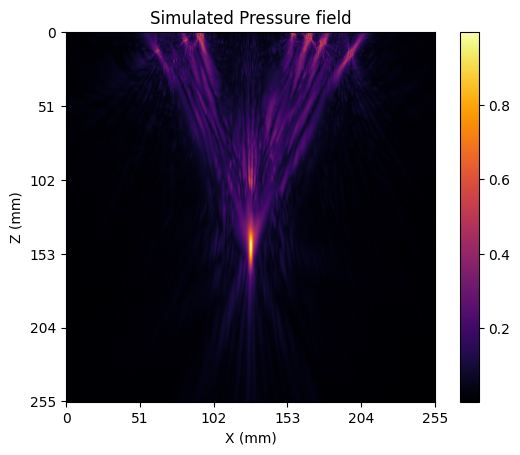

In [121]:
data_sim=np.load('Sims/data/pressure_data_max.npy')
data_sim = data_sim.reshape(512,512)

sample_spacing = 0.5  # mm per sample

fig, ax = plt.subplots()
im = ax.imshow(data_sim, cmap='inferno', vmin=data_sim.min(), vmax=data_sim.max())

# Set new tick locations and labels in mm
num_ticks = 6  # Number of major ticks
tick_positions = np.linspace(0, data_sim.shape[1]-1, num_ticks)  # Evenly spaced sample positions
tick_labels = (tick_positions * sample_spacing).astype(int)  # Convert to mm

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_positions)
ax.set_yticklabels(tick_labels)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Z (mm)")
ax.set_title("Simulated Pressure field")

fig.colorbar(im, ax=ax)

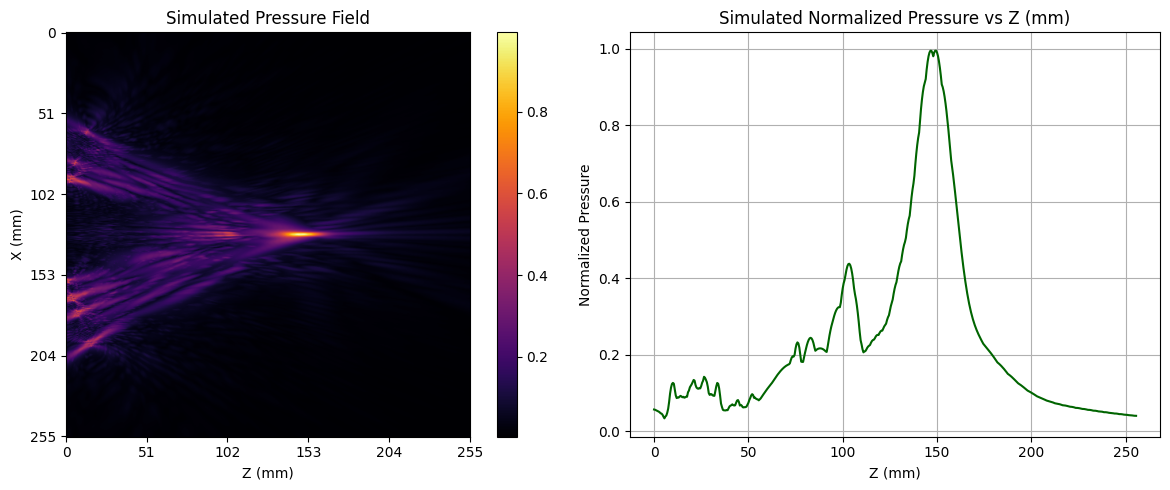

In [127]:
data_sim = np.load('Sims/data/pressure_data_max.npy')
data_sim = data_sim.reshape(512, 512)

sample_spacing = 0.5  # mm per sample

# Create figure with two subplots: imshow + line plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Pressure field
im = ax1.imshow(data_sim.T, cmap='inferno', vmin=data_sim.min(), vmax=data_sim.max())

# Set new tick locations and labels in mm
num_ticks = 6
tick_positions = np.linspace(0, data_sim.shape[1]-1, num_ticks)
tick_labels = (tick_positions * sample_spacing).astype(int)

ax1.set_xticks(tick_positions)
ax1.set_xticklabels(tick_labels)
ax1.set_yticks(tick_positions)
ax1.set_yticklabels(tick_labels)

ax1.set_xlabel("Z (mm)")
ax1.set_ylabel("X (mm)")
ax1.set_title("Simulated Pressure Field")

fig.colorbar(im, ax=ax1)

# Second subplot: Amplitude at z = 356
z_index = 255
x_values = np.arange(data_sim.shape[0]) * sample_spacing  # Convert x indices to mm
amplitude_slice = data_sim[:, z_index]

ax2.plot(x_values, amplitude_slice, color='darkgreen')
ax2.set_title(f"Simulated Normalized Pressure vs Z (mm)")
ax2.set_xlabel("Z (mm)")
ax2.set_ylabel("Normalized Pressure")
ax2.grid(True)

plt.tight_layout()
plt.show()

In [33]:
np.argmax(data_sim)

np.int64(152831)

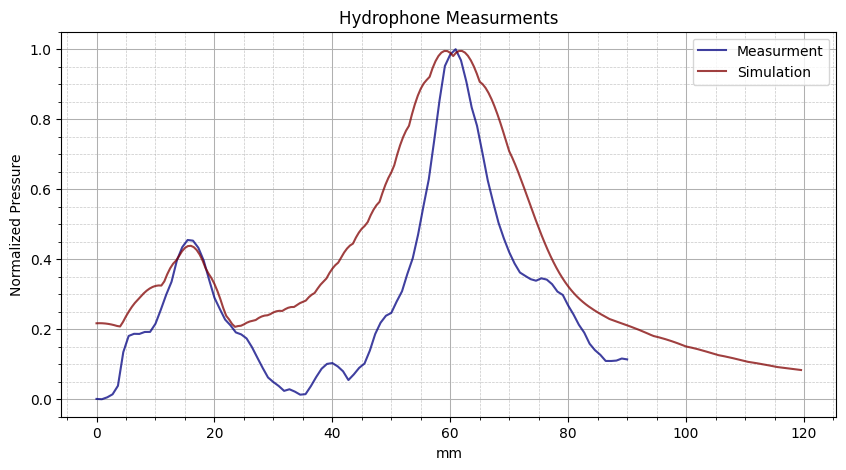

In [123]:
# Plot the series with error bars|
x_values_meas = np.arange(num_of_samples) * steps_per_sample / steps_per_mm
x_values_sim = np.arange(240) * sample_spacing  # Convert x indices to mm
normalized = (mean_series_max - np.min(mean_series_max)) / (np.max(mean_series_max) - np.min(mean_series_max))

plt.figure(figsize=(10, 5))
plt.plot(x_values_meas, normalized, color='navy', alpha=0.75, label='Measurment')
plt.plot(x_values_sim, amplitude_slice, color='maroon', alpha=0.75, label='Simulation')
plt.xlabel("mm")
plt.ylabel("Normalized Pressure")
plt.title("Hydrophone Measurments")
plt.legend()
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', linewidth=0.75)  # Thicker lines for major grid
plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)  # Thinner dashed lines for minor grid
plt.show()